# Predicting Subscription to Term Deposit

Author: Pinge Chen

Course Project, UC Irvine, Math 10, F24

I would like to post my notebook on the course's website. Yes

## **1.Introduction**

This data is from the Bank Marketing task from UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/222/bank+marketing). The 45,211 entries with 16 features of data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The classification goal is to predict whether a client will subscribe to a term deposit, represented by the target variable y, which is binary:

y = 1 (Yes): The client subscribed to a term deposit.

y = 0 (No): The client did not subscribe to a term deposit.


The dataset includes information about:

Client-specific attributes: Age, job, marital status, education level, and financial details.

Campaign-related attributes: Number of contacts, previous campaign outcomes, and time-related variables (month, day of the week).

External attributes: Economic context features such as employment variation rate and consumer confidence index.

| Variable Name | Role    | Type         | Demographic      | Description                                                                                                         | Units | Missing Values |
|---------------|---------|--------------|------------------|---------------------------------------------------------------------------------------------------------------------|-------|----------------|
| age           | Feature | Integer      | Age              |                                                                                                                     |       | no             |
| job           | Feature | Categorical  | Occupation       | type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown') |       | no             |
| marital       | Feature | Categorical  | Marital Status   | marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed) |       | no             |
| education     | Feature | Categorical  | Education Level  | (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown') |       | no             |
| default       | Feature | Binary       |                  | has credit in default?                                                                                              |       | no             |
| balance       | Feature | Integer      |                  | average yearly balance                                                                                              | euros | no             |
| housing       | Feature | Binary       |                  | has housing loan?                                                                                                   |       | no             |
| loan          | Feature | Binary       |                  | has personal loan?                                                                                                  |       | no             |
| contact       | Feature | Categorical  |                  | contact communication type (categorical: 'cellular', 'telephone')                                                  |       | yes            |
| day_of_week   | Feature | Date         |                  | last contact day of the week                                                                                        |       | no             |
| month         | Feature | Date         |                  | last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')                                                                                                                                                                                                                |        | no             |
| duration      | Feature | Integer      |                  | last contact duration, in seconds (numeric). **Important note:** this attribute highly affects the output target (e.g., if duration=0 then y='no'). However, the duration is not known before a call is performed. Thus, it should only be included for benchmark purposes and excluded in realistic predictive models. | seconds | no             |
| campaign      | Feature | Integer      |                  | number of contacts performed during this campaign and for this client (numeric, includes last contact)                                                                                                                                                                                          |        | no             |
| pdays         | Feature | Integer      |                  | number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)                                                                                                                                              |        | yes            |
| previous      | Feature | Integer      |                  | number of contacts performed before this campaign and for this client                                                                                                                                                                                                                          |        | no             |
| poutcome      | Feature | Categorical  |                  | outcome of the previous marketing campaign (categorical: 'failure', 'nonexistent', 'success')                                                                                                                                                                                                   |        | yes            |
| y             | Target  | Binary       |                  | has the client subscribed to a term deposit?                                                                                                                                                                                                                                                    |        | no             |


In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd  
# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
  
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
  
# metadata 
# print(bank_marketing.metadata) 
  
# variable information 
# print(bank_marketing.variables)

## **2.Data Cleaning**

I am going to approach this by:
1) Dropping irrelevant rows and columns
2) Encoding categorical features

In [2]:
X.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


### **Dropping irrelavant columns and value-missing rows.**

I am **dropping** some of the columns that are subjectively irrelevant to me: 

1) job: This feature includes 11 distinct value, making it very hard to encode for the regression to work in the future. If use one-hot encoding, there will be a huge increase in dimensionality. If use ordinal encoding, there is no internal order for job types. Additionally, it is hard for me to subjectively assign values to each job type. Thus, I am dropping this feature.

2) poutcome: Even though this feature should be very useful intuitively, however, there are 36959/45211 missing values, which is too much. Keep this feature will require me to drop all the rows with missing value, costing me a lot of other information. Thus, I am dropping this feature.

3) duration: This feature was said to be dropped by the author. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

4) contact: I am dropping this feature because it is irrelevant to me intuitively.

I am **transforming** these columns:

1) day_of_week & month: These features together can represent the last contact date of the current campaign. Putting them together and representing them as a difference between today's date (assuming December 8th) and the date itself is more meaningful.

In [3]:
df = X.drop(columns=['job', 'poutcome', 'duration', 'contact'], axis=1)

df.head()

,age,marital,education,default,balance,housing,loan,day_of_week,month,campaign,pdays,previous
0,58,married,tertiary,no,2143,yes,no,5,may,1,-1,0
1,44,single,secondary,no,29,yes,no,5,may,1,-1,0
2,33,married,secondary,no,2,yes,yes,5,may,1,-1,0
3,47,married,NaN,no,1506,yes,no,5,may,1,-1,0
4,33,single,NaN,no,1,no,no,5,may,1,-1,0


In [4]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

df['month'] = df['month'].map(month_map)

df['date'] = pd.to_datetime(
    dict(year=2024, month=df['month'], day=df['day_of_week'])
)

df = df.drop(columns=['month', 'day_of_week'])

reference_date = pd.Timestamp('2024-12-08')

df['days_since_contact'] = (reference_date - df['date']).dt.days

df = df.drop(columns=['date'])

Next step is to drop the rows with missing-values, but before that, I am going to append y to df so that we don't have to match the outcomes one by one.

In [5]:
df['y'] = y

I am **dropping** rows with missing-values.

In [6]:
df = df.dropna()

### **Encoding Categorical Features**

I am **one-hot encoding** the categorical features for easier usage in regression models: marital, education

I am **maping** housing, loan, default and also y to 1 and 0.

In [7]:
df = pd.get_dummies(df, columns=['marital', 'education'], drop_first=True)

df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})

df['y'] = df['y'].map({'yes': 1, 'no': 0})

## **3.Exploratory Data Analysis (EDA)**

As data cleaning is now complete, we will move on to EDA and gain some understanding of the data.

In [8]:
df.describe()

,age,default,balance,housing,loan,campaign,pdays,previous,days_since_contact,y
count,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000,43354.000000
mean,40.783111,0.018061,1355.226715,0.560733,0.164022,2.760184,40.340960,0.584260,170.662061,0.116183
std,10.518987,0.133172,3039.916830,0.496304,0.370300,3.065496,100.331955,2.329661,74.843025,0.320448
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,-22.000000,0.000000
25%,33.000000,0.000000,71.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,124.000000,0.000000
50%,39.000000,0.000000,443.000000,1.000000,0.000000,2.000000,-1.000000,0.000000,187.000000,0.000000
75%,48.000000,0.000000,1415.000000,1.000000,0.000000,3.000000,-1.000000,0.000000,213.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,58.000000,871.000000,275.000000,337.000000,1.000000


In [9]:
df.head(5)

,age,default,balance,housing,loan,campaign,pdays,previous,days_since_contact,y,marital_married,marital_single,education_secondary,education_tertiary
0,58,0,2143,1,0,1,-1,0,217,0,True,False,False,True
1,44,0,29,1,0,1,-1,0,217,0,False,True,True,False
2,33,0,2,1,1,1,-1,0,217,0,True,False,True,False
5,35,0,231,1,0,1,-1,0,217,0,True,False,False,True
6,28,0,447,1,1,1,-1,0,217,0,False,True,False,True


With some basic information above, I now want to explore the distribution of the outcome variable y.

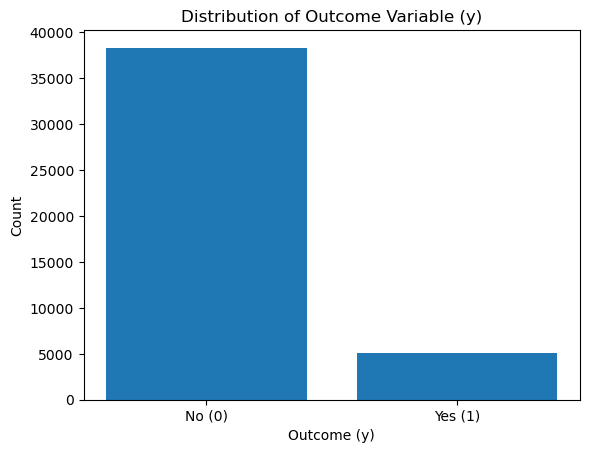

In [10]:
import matplotlib.pyplot as plt

y_counts = df['y'].value_counts()

plt.bar(y_counts.index, y_counts.values, tick_label=['No (0)', 'Yes (1)'])
plt.xlabel('Outcome (y)')
plt.ylabel('Count')
plt.title('Distribution of Outcome Variable (y)')
plt.show()

In [11]:
y_counts = df['y'].value_counts()
class_proportions = y_counts / len(df)

print(f"Class Counts:\n{y_counts}")
print(f"\nClass Proportions:\n{class_proportions}")

Class Counts:
y
0    38317
1     5037
Name: count, dtype: int64

Class Proportions:
y
0    0.883817
1    0.116183
Name: count, dtype: float64


We can see that there is a significant **class imbalance** for the outcome variable y.

The majority of clients **did not subscribe** to a term deposit (y=0), while only a small percentage subscribed (y=1).

This imbalance means my dataset is skewed toward the majority class, making it harder for a model to accurately predict the minority class (y=1).

This also means that the minority class (y=1) is underrepresented, and special care (**resampling or reweighting**) will be needed to ensure the model can handle this.

If a model always predicts the majority class (y=0), the baseline accuracy will equal the proportion of y=0, which in this case is 88%.

Next, I want to see if there is a linear relationship between age and balanc. As I believe, an individual with higher age should be correlated with a higher average yearly balance. I will apply **Linear Regression** to test this.

Intercept: 210.42
Coefficient: 28.07


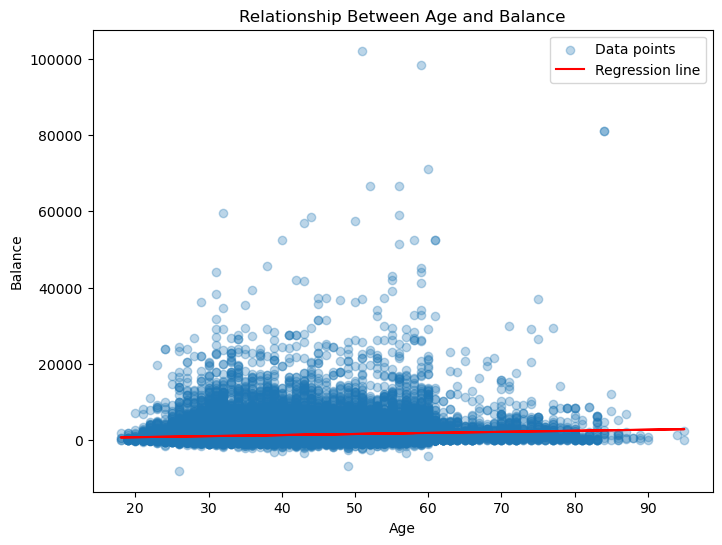

In [12]:
from sklearn.linear_model import LinearRegression

X = df[['age']]
y = df['balance']

model = LinearRegression()
model.fit(X, y)

print(f"Intercept: {model.intercept_:.2f}")
print(f"Coefficient: {model.coef_[0]:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.3, label='Data points')
plt.plot(X, model.predict(X), color='red', label='Regression line')
plt.xlabel("Age")
plt.ylabel("Balance")
plt.title("Relationship Between Age and Balance")
plt.legend()
plt.show()

The data points are widely dispersed, and there doesn’t appear to be a strong pattern or trend between age and balance.
The red regression line is almost flat, showing a near-zero slope. This further confirms the lack of a significant relationship between the two variables

Now, lets build a **heat map** to see how the features are related to each other.

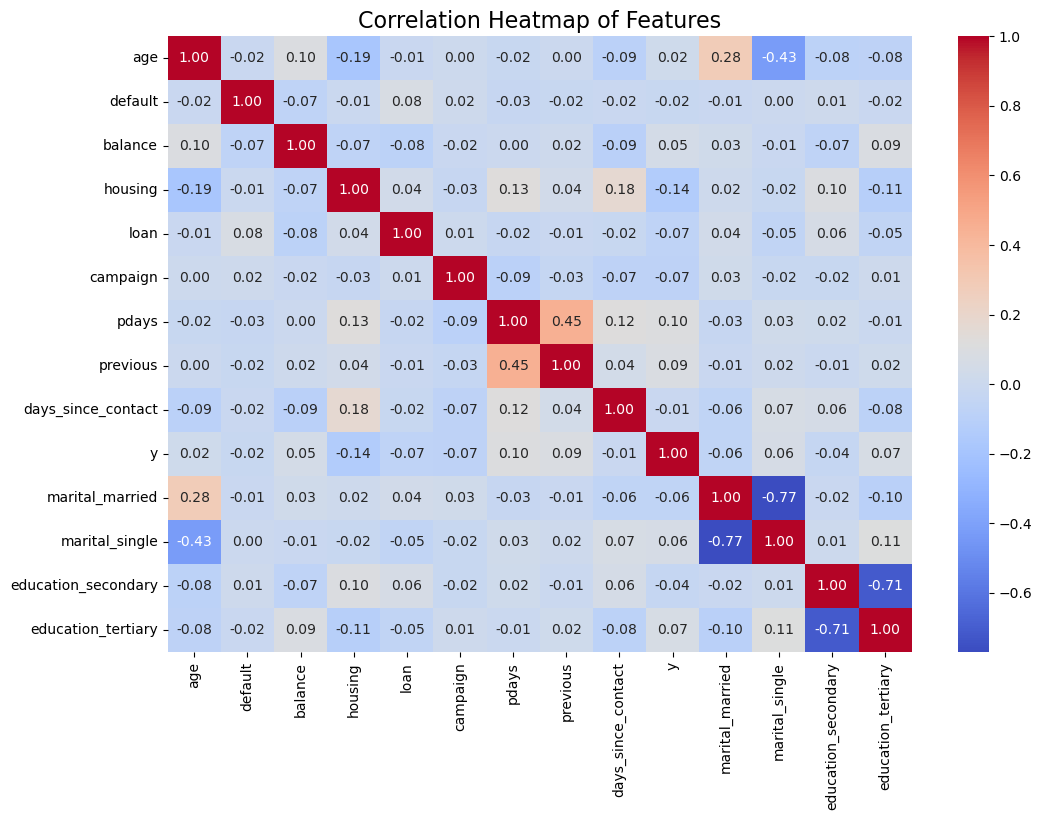

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

There is not much useful information given this heat map. Some takeaways are:

age and y (0.02): Indicates no significant linear relationship between age and the likelihood of subscribing to a term deposit.
default and y (-0.02): Default status has almost no relationship with the target variable.
These variables are likely going to be dropped if I apply **Lasso Regularization**.

**Multicollinearity** might exist. pdays and previous (0.45): These features have a moderate positive correlation. This could indicate redundancy, and one of these features might be removed during feature selection.

The weak correlation between most features and the target variable (y) suggests that no single feature strongly predicts the likelihood of subscribing to a term deposit. The model will likely need to rely on **combinations of features**.

Next, I am going to split the data into training and testing data after I use **oversampling** to solve the class imbalance.

In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:", Counter(y_train))
print("Balanced training set class distribution:", Counter(y_train_balanced))

Original training set class distribution: Counter({0: 30653, 1: 4030})
Balanced training set class distribution: Counter({0: 30653, 1: 30653})


## **4.Logistic Regression**

Since the problem is a binary classification problem, it is more reasonable to use Logistic Regression.

First, I will **scale** the numerical features.

In [15]:
from sklearn.preprocessing import StandardScaler
import numpy as np

numeric_features = ['age', 'balance', 'campaign', 'pdays', 'previous', 'days_since_contact']
categorical_features = ['default', 'housing', 'loan', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary']

scaler = StandardScaler()

X_train_scaled_numeric = scaler.fit_transform(X_train_balanced[numeric_features])
X_test_scaled_numeric = scaler.transform(X_test[numeric_features])

X_train_scaled = np.hstack([
    X_train_scaled_numeric, 
    X_train_balanced[categorical_features].values
])
X_test_scaled = np.hstack([
    X_test_scaled_numeric, 
    X_test[categorical_features].values
])

Next, I am training the **Logistic Regression Model** with the balanced and scaled X_train and the balanced y_train.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

logistic_model = LogisticRegression(max_iter=1000, random_state=42)

logistic_model.fit(X_train_scaled, y_train_balanced)

coefficients = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Coefficient': logistic_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

Next, I am plotting the **Confusion Matrix** as an visualization of the result and calculating the accuracy score.

Accuracy: 0.77


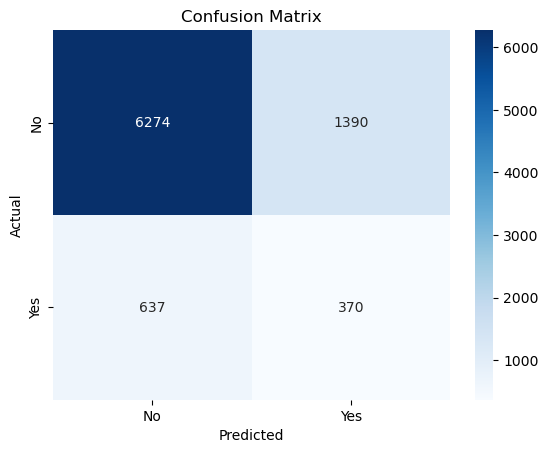

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = logistic_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

True Negatives (TN = 6274):
The model correctly predicted "No" (class 0) for 6274 clients who actually did not subscribe to a term deposit.

False Positives (FP = 1390):
The model incorrectly predicted "Yes" (class 1) for 1390 clients who actually did not subscribe.

False Negatives (FN = 637):
The model incorrectly predicted "No" (class 0) for 637 clients who actually subscribed.

True Positives (TP = 370):
The model correctly predicted "Yes" (class 1) for 370 clients who actually subscribed.

I am aware that **Lasso Regularization** is used to prevent overfitting, but I'd still like to try if it improves my results. I am also implementing **GridSearch** for hyperparameter tuning.

Best Regularization Strength (C): {'C': 1}
Accuracy: 0.77


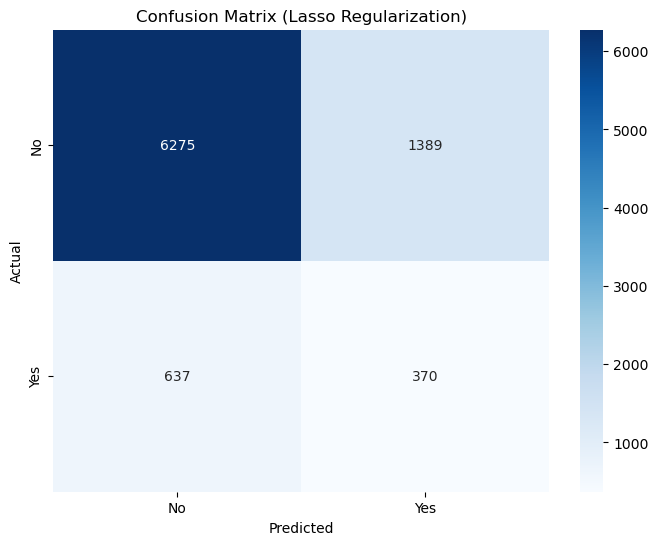

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(logistic_lasso, param_grid, scoring='accuracy', cv=5)
grid.fit(X_train_scaled, y_train_balanced)

print("Best Regularization Strength (C):", grid.best_params_)
best_lasso_model = grid.best_estimator_

best_lasso_model.fit(X_train_scaled, y_train_balanced)

y_pred_lasso = best_lasso_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_lasso)
cm = confusion_matrix(y_test, y_pred_lasso)

print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Lasso Regularization)')
plt.show()

Both Logistic Regression and Logistic Regression with Lasso achieve 77% accuracy. This is lower than the baseline accuracy but demonstrates that the model is attempting to balance predictions for both classes, rather than always predicting the majority class.

A model achieving 77% accuracy while predicting both classes is more meaningful than a naive model achieving 88% accuracy but ignoring one class entirely.

I need to focus on metrics beyond accuracy to measure the performance of my models. I am going to use **Recall**.

In [19]:
from sklearn.metrics import recall_score

y_pred_logistic = logistic_model.predict(X_test_scaled)

y_pred_lasso = best_lasso_model.predict(X_test_scaled)

recall_logistic = recall_score(y_test, y_pred_logistic)
print(f"Recall (Logistic Regression): {recall_logistic:.2f}")

recall_lasso = recall_score(y_test, y_pred_lasso)
print(f"Recall (Logistic Regression with Lasso): {recall_lasso:.2f}")

Recall (Logistic Regression): 0.37
Recall (Logistic Regression with Lasso): 0.37


Sadly, changing the metrics doesn't change the fact that the model is poorly performing on predicting the Yes category.
With a recall of 0.37, my model struggles to capture the majority of potential subscribers, which is problematic if the goal is to target clients likely to subscribe.

Next, I am going to use the **K Nearest Neighbor Model** to see if this nonparametric model can produce a better result.

## **5.KNN Model**

KNN Accuracy: 0.78
KNN Recall: 0.41


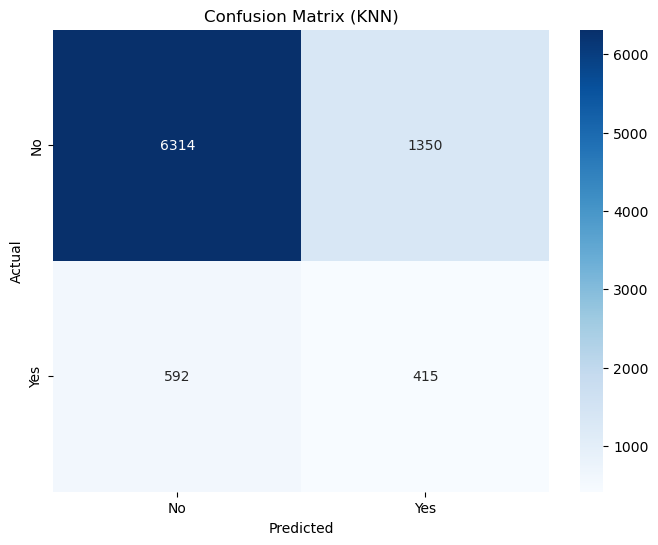

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled, y_train_balanced)

y_pred_knn = knn.predict(X_test_scaled)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print(f"KNN Accuracy: {accuracy_knn:.2f}")
print(f"KNN Recall: {recall_knn:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (KNN)')
plt.show()

Next, I will use GridSearch again to identify the best parameters.

In [21]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

grid_knn = GridSearchCV(knn, param_grid, scoring='recall', cv=5)
grid_knn.fit(X_train_scaled, y_train_balanced)

best_knn = grid_knn.best_estimator_

y_pred_best_knn = best_knn.predict(X_test_scaled)
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
recall_best_knn = recall_score(y_test, y_pred_best_knn)

print(f"Best KNN Accuracy: {accuracy_best_knn:.2f}")
print(f"Best KNN Recall: {recall_best_knn:.2f}")

Best KNN Accuracy: 0.78
Best KNN Recall: 0.40


Accuracy = 0.78:

The KNN model achieves an accuracy of 78%, which is slightly better than the Logistic Regression model's 77%.

Recall = 0.40:

The KNN model achieves a recall of 40%, which is better than the Logistic Regression model’s recall of 37%. This means that the KNN model correctly identifies 40% of the actual positive cases (y=1), making it slightly better at capturing the minority class (clients who subscribed to the term deposit).

The improvement in recall suggests that KNN is slightly better at identifying the minority class (y=1), even though the overall improvement is modest.

Next, I want to try **clustering** and see if it gives any suprising results.

## **6.Clustering with K-Means and PCA for Dimensionality Reduction**

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_train_scaled)

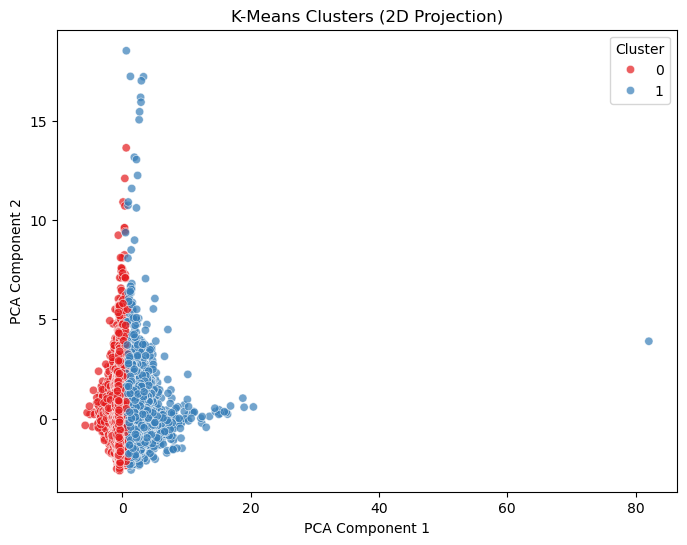

In [23]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=cluster_labels, palette='Set1', alpha=0.7)
plt.title('K-Means Clusters (2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

To be honest, I am suprised by the above graph as in I do not understand a thing about what the graph is telling me. So I asked ChatGPT to interpret the graph for me. And here are some understandings:

There is a significant overlap between the clusters in the lower-left region of the plot, indicating that the features may not provide enough separation for distinct groups.

The points in Cluster 1 (blue) extend further along PCA Component 1, suggesting this cluster captures samples with distinct characteristics on the principal feature captured by the PCA.

Significant overlap in the clusters **aligns** with my classification models (Logistic Regression, KNN) struggling to achieve higher recall for the minority class.

In the above code, I have given that there are 2 clusters. For fun, I want to test if not given that information, how many clusters will minimize loss. 

**The following code is directly copied from the Clustering file posted by instructor.**

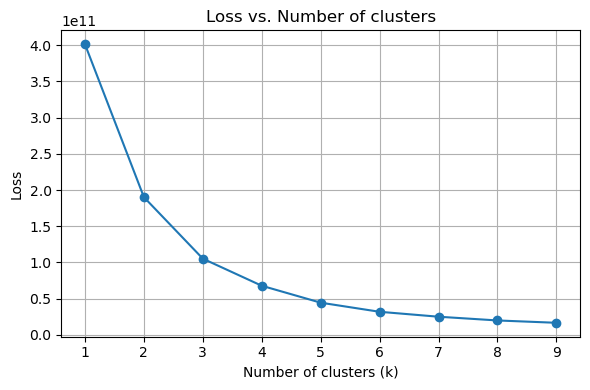

In [24]:
# Range of k values
k_values = range(1, 10)
inertias = []

# Apply k-Means for different values of k and record the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Plotting the results
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Loss (inertia) plot
ax.plot(k_values, inertias, marker='o')
ax.set_title('Loss vs. Number of clusters')
ax.set_xlabel('Number of clusters (k)')
ax.set_ylabel('Loss')
ax.grid(True)

plt.tight_layout()
plt.show()

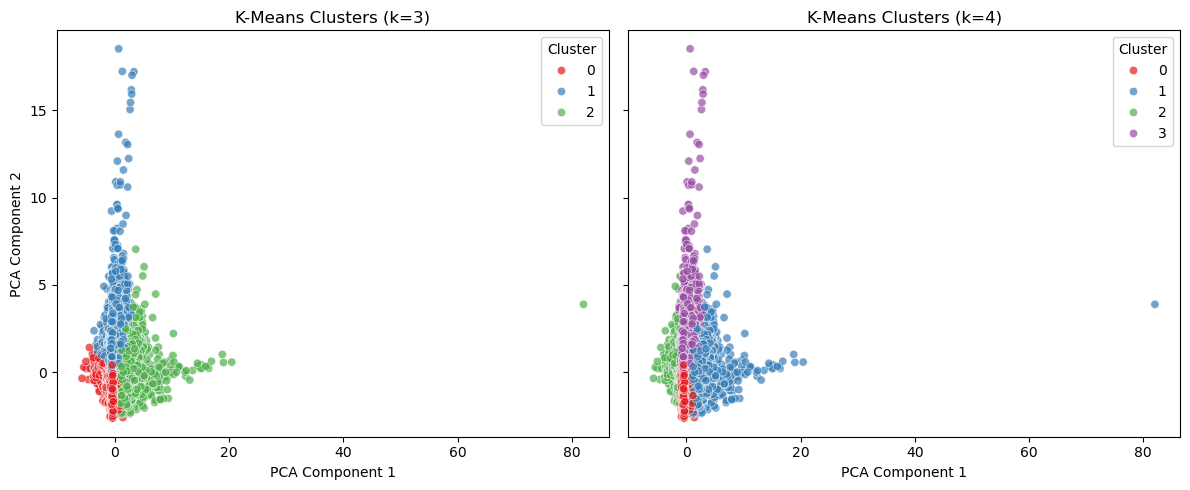

In [25]:
cluster_numbers = [3, 4]

fig, axes = plt.subplots(1, len(cluster_numbers), figsize=(12, 5), sharex=True, sharey=True)

for idx, n_clusters in enumerate(cluster_numbers):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_train_scaled)
    
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    ax = axes[idx]
    sns.scatterplot(
        x=X_train_pca[:, 0], 
        y=X_train_pca[:, 1], 
        hue=cluster_labels, 
        palette='Set1', 
        alpha=0.7, 
        ax=ax
    )
    ax.set_title(f'K-Means Clusters (k={n_clusters})')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.legend(title='Cluster')

plt.tight_layout()
plt.show()

It is interesting to see that the program believes that k=3 or k=4 is the best k to choose, instead of k=2 as intended. This might mean that clustering is not a good way to solve this problem, or it means that there are insufficient information from the original dataset to determine the clusters.

Next, I am going to try **Random Forest**.

## **7.Random Forest**

Random Forest Accuracy: 0.84
Random Forest Recall: 0.37
Confusion Matrix:
[[6879  785]
 [ 631  376]]


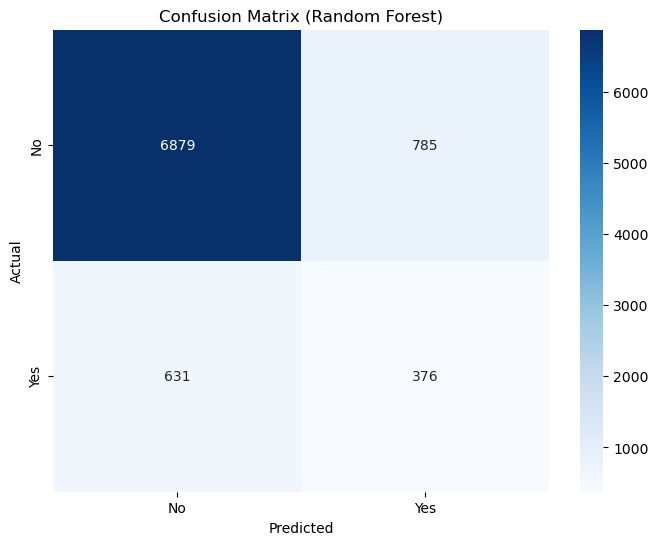

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)

rf.fit(X_train_scaled, y_train_balanced)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

recall_rf = recall_score(y_test, y_pred_rf)
print(f"Random Forest Recall: {recall_rf:.2f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

I have learnt that with Random Forest, you can actually see the importance of the features.

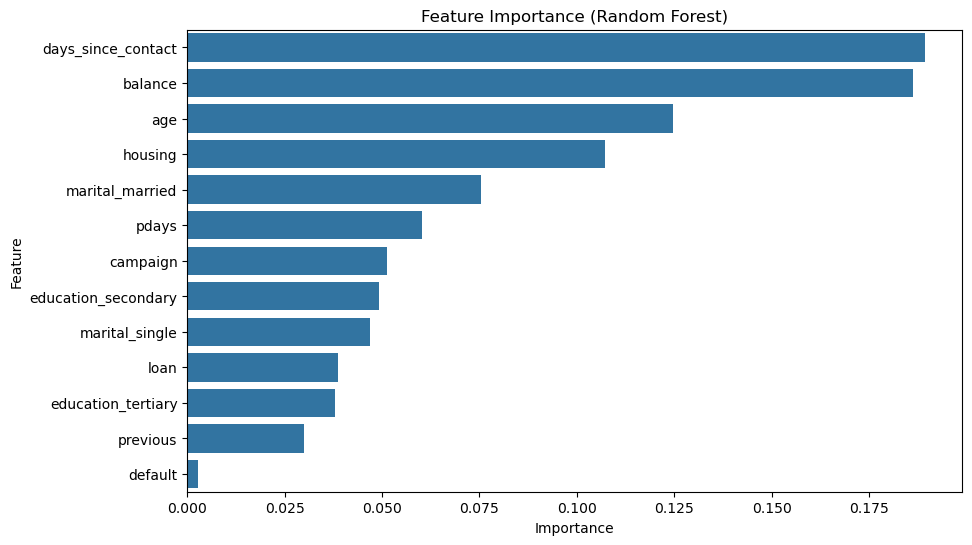

In [27]:
feature_importances = rf.feature_importances_
features = ['age', 'balance', 'campaign', 'pdays', 'previous', 'days_since_contact', 
            'default', 'housing', 'loan', 'marital_married', 'marital_single', 
            'education_secondary', 'education_tertiary']
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.show()

In the graph, we can see that days_since_contact and balance are the two most important features, which is surprising.

## **8.Conclusion**

In this project, I have the goal of predicting subscription based on given features. I have used multiple models, including Logistic Regression Model, Logistic Regression Model with Lasso, KNN, K-means Clustering, and Random Forest. Since the model had a skewed distribution between majority and minority, accuracy cannot be an effective measure for the models' performance. Instead, we should look at the recall score. The best recall score was given by the KNN model of k=5 with 40%. However, it is still inefficient in predicting the correct classes. I have done everything that I could think of based on my current knowledge. If I had the chance to learn more techniques, maybe ways to preprocess the data, or new models, I might achieve better results.